In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib

In [48]:
#Loading Data
try:
    train = pd.read_csv('sales_train.csv')
    items = pd.read_csv('items.csv')
    item_categories = pd.read_csv('item_categories.csv')
    shops = pd.read_csv('shops.csv')
    test = pd.read_csv('test.csv')
    print("All CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure all CSV files are in the same directory.")
    exit()

All CSV files loaded successfully.


In [49]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [51]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [52]:
train['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [53]:
len(train['shop_id'].unique())

60

In [54]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [55]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [56]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [57]:
len(shops['shop_name'].unique())

60

In [58]:
len(shops['shop_id'].unique())

60

In [59]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [60]:
len(test['shop_id'].unique())

42

<Axes: xlabel='item_price'>

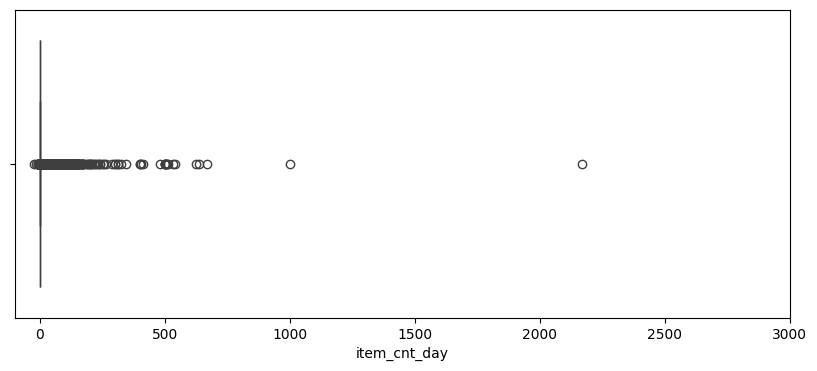

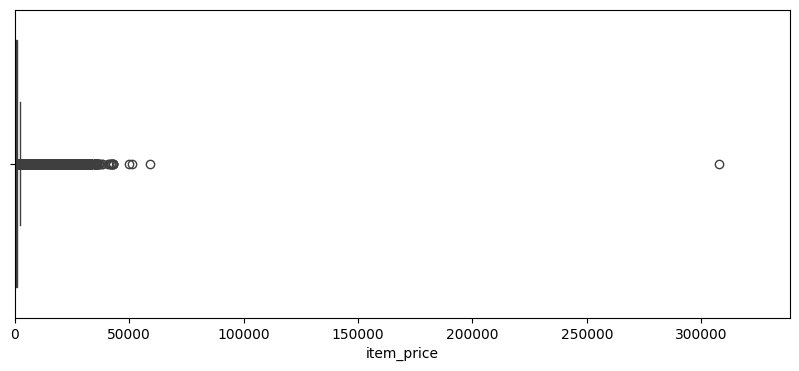

In [61]:
#Visualizing box plot of item_cnt_day and item_price
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [62]:
#Removing outliers based on the box plot
train=train[train['item_cnt_day']<1100]
train=train[train['item_price']<100000]

In [63]:
train[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [64]:
#Filling the one with price less than zero with median
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [65]:
print('***************sales_train*********************')
print(train.nunique())
print('****************items********************')
print(items.nunique())
print('*****************item_categories*******************')
print(item_categories.nunique())
print('*****************shops*******************')
print(shops.nunique())
print('*****************test*******************')
print(test.nunique())


***************sales_train*********************
date               1034
date_block_num       34
shop_id              60
item_id           21806
item_price        19990
item_cnt_day        197
dtype: int64
****************items********************
item_name           22170
item_id             22170
item_category_id       84
dtype: int64
*****************item_categories*******************
item_category_name    84
item_category_id      84
dtype: int64
*****************shops*******************
shop_name    60
shop_id      60
dtype: int64
*****************test*******************
ID         214200
shop_id        42
item_id      5100
dtype: int64


In [66]:
# Convert date to datetime
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

# Check for missing values
print(train.isnull().sum())
print('**************************************************')
print(items.isnull().sum())
print('**************************************************')
print(item_categories.isnull().sum())
print('**************************************************')
print(shops.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
**************************************************
item_name           0
item_id             0
item_category_id    0
dtype: int64
**************************************************
item_category_name    0
item_category_id      0
dtype: int64
**************************************************
shop_name    0
shop_id      0
dtype: int64


In [67]:
#Dropping duplicate rows
train=train.drop_duplicates()

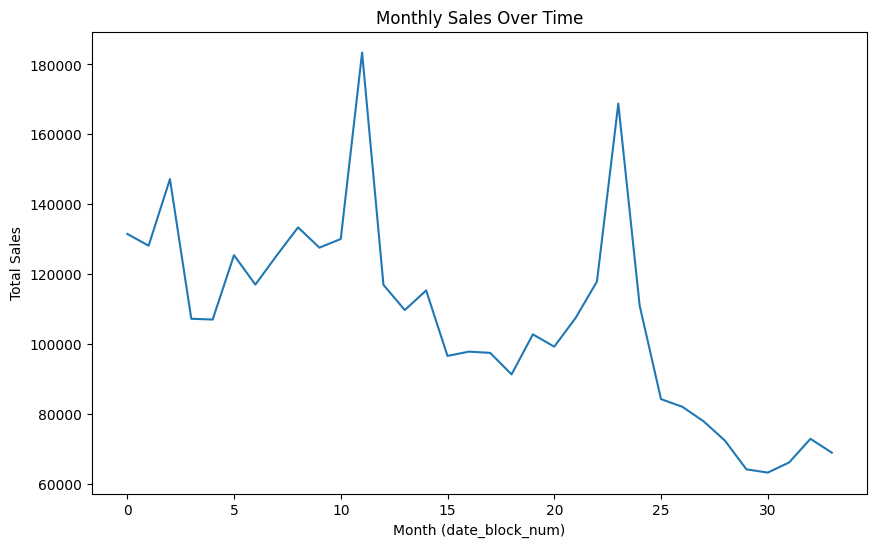

In [68]:
# Aggregate monthly sales
# Plot sales trends over time
plt.figure(figsize=(10,6))
plt.plot(train.groupby('date_block_num')['item_cnt_day'].sum())
plt.title('Monthly Sales Over Time')
plt.xlabel('Month (date_block_num)')
plt.ylabel('Total Sales')
plt.show()

In [69]:
# Top 10 items by total sales
top_items = train.groupby('item_id')['item_cnt_day'].sum().sort_values(ascending=False).head(10)
print(top_items)

item_id
20949    187642.0
2808      17245.0
3732      16642.0
17717     15830.0
5822      14515.0
3734      11688.0
6675      10289.0
3731      10099.0
1855      10032.0
16787      9227.0
Name: item_cnt_day, dtype: float64


<Axes: xlabel='item_price', ylabel='Count'>

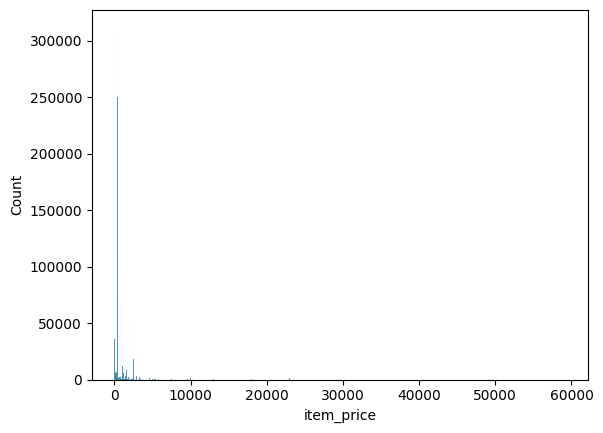

In [70]:
#Plotting the distribution of price
sns.histplot(train['item_price'])


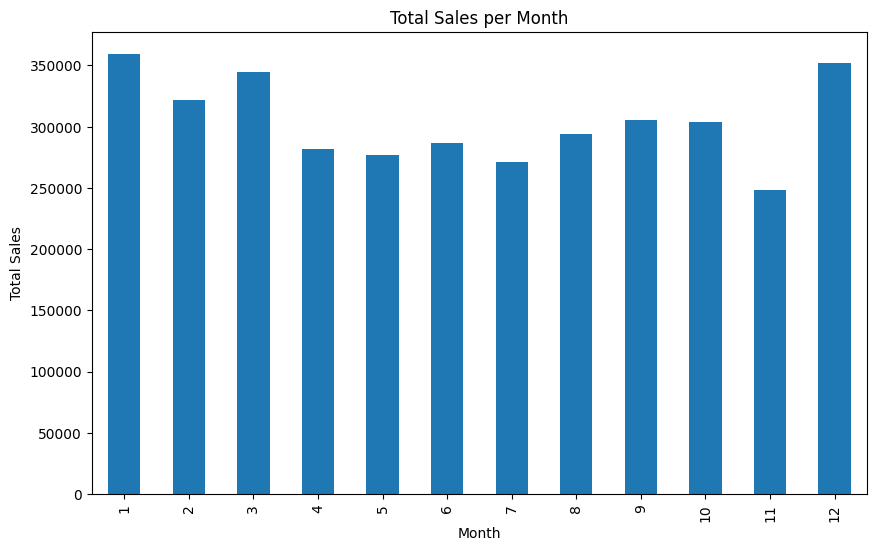

In [71]:
#To check for seasonality
# Add 'month' column
train['month'] = train['date'].dt.month

# Aggregate sales by month
monthly_sales_by_month = train.groupby('month')['item_cnt_day'].sum()

# Plot
plt.figure(figsize=(10,6))
monthly_sales_by_month.plot(kind='bar')
plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

In [72]:
train.drop('month',axis=1,inplace=True)

In [73]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [74]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [75]:
#Converting to monthly sales
monthly_sales = (
    train.groupby(['date_block_num', 'shop_id', 'item_id'])
    .agg(item_cnt_month=('item_cnt_day', 'sum'))
    .reset_index()
)

In [76]:
monthly_sales

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609118,33,59,22087,6.0
1609119,33,59,22088,2.0
1609120,33,59,22091,1.0
1609121,33,59,22100,1.0


In [77]:
#Create shop-month-item grid
grid = []
for block_num in range(34):
    cur_shops = train[train['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num'] == block_num]['item_id'].unique()
    grid += list(np.array(np.meshgrid([block_num], cur_shops, cur_items)).T.reshape(-1, 3))

grid_df = pd.DataFrame(grid, columns=['date_block_num', 'shop_id', 'item_id'])

# Merge with aggregated monthly sales
full_data = pd.merge(grid_df, monthly_sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')
full_data['item_cnt_month'] = full_data['item_cnt_month'].fillna(0)

In [78]:
full_data

,date_block_num,shop_id,item_id,item_cnt_month
0,0,59,22154,1.0
1,0,25,22154,5.0
2,0,24,22154,1.0
3,0,23,22154,0.0
4,0,19,22154,0.0
...,...,...,...,...
10913799,33,28,7440,0.0
10913800,33,26,7440,0.0
10913801,33,25,7440,1.0
10913802,33,24,7440,0.0


In [79]:
#Creating Lag Features
def create_lag_feature(df, lags, col):
    for lag in lags:
        temp = df[['date_block_num', 'shop_id', 'item_id', col]].copy()
        temp['date_block_num'] += lag
        temp = temp.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_month'].mean().reset_index()
        temp.rename(columns={col: f'{col}_lag_{lag}'}, inplace=True)
        df = pd.merge(df, temp, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

full_data = create_lag_feature(full_data, [1, 2, 3], 'item_cnt_month')

In [80]:
#Rolling Mean Features
full_data['item_cnt_month_rolling_mean_3'] = (
    full_data[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']]
    .mean(axis=1)
)

# Fill missing values
full_data.fillna(0, inplace=True)

In [82]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Filter training data (exclude the last month for validation)
X = full_data[full_data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y = full_data[full_data['date_block_num'] < 33]['item_cnt_month']

# Validation on month 33 (October 2015)
X_val = full_data[full_data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_val = full_data[full_data['date_block_num'] == 33]['item_cnt_month']

# Train model
model = XGBRegressor(max_depth=8, n_estimators=100, learning_rate=0.1, n_jobs=-1)
model.fit(X, y)

# Predict
y_pred = model.predict(X_val).clip(0, 20)

# Evaluate
rmse = mean_squared_error(y_val, y_pred)
print("Validation RMSE:", rmse)

Validation RMSE: 6.493173744801642


In [83]:
# Prepare test set
test=pd.read_csv('test.csv')
test['date_block_num'] = 34
new_full_data=full_data.drop('date_block_num',axis=1)
test_set = pd.merge(test, new_full_data, on=['shop_id', 'item_id'], how='left')
test_set['item_cnt_month_rolling_mean_3'] = test_set[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].mean(axis=1)
test_set.drop_duplicates(inplace=True)


In [84]:
#Forecasting for test set
X_test = test_set.drop(['ID','item_cnt_month'], axis=1)
X_test = X_test[X.columns]
test_predictions = model.predict(X_test)
test_set['item_cnt_month'] = test_predictions

In [85]:
test_set

,ID,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_rolling_mean_3
0,0,5,5037,34,0.111118,0.0,0.0,0.0,0.000000
1,0,5,5037,34,0.280088,1.0,0.0,0.0,0.333333
2,0,5,5037,34,0.224402,0.0,1.0,0.0,0.333333
3,0,5,5037,34,0.437680,1.0,0.0,1.0,0.666667
4,0,5,5037,34,0.796017,2.0,1.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...
2790525,214199,45,969,34,0.766775,1.0,3.0,0.0,1.333333
2790526,214199,45,969,34,0.887079,1.0,1.0,3.0,1.666667
2790527,214199,45,969,34,0.316531,0.0,1.0,1.0,0.666667
2790528,214199,45,969,34,0.177095,0.0,0.0,1.0,0.333333


In [86]:
import joblib
joblib.dump(model, "model.joblib")

['model.joblib']

In [87]:
model.save_model('model.json')